In [1]:
import os
import pandas as pd
import zipfile
import io
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt

# ---------------------------------------------
# Data and Directory Setup
# ---------------------------------------------
os.chdir("E:/Assignment/Introduction to Deep Learning/Week 3")

# Load the labels CSV
df = pd.read_csv("train_labels.csv")
print(f"Total samples: {len(df)}")
df.head()


Total samples: 220025


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


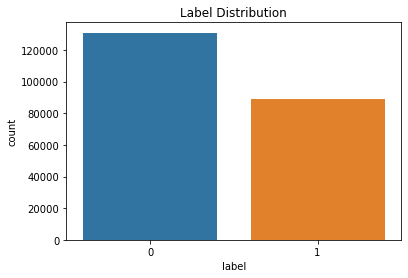

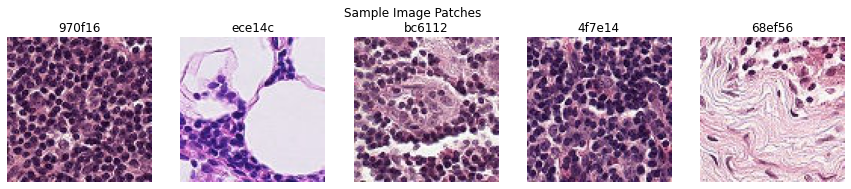

In [2]:
# Exploratory Data Analysis (EDA)
# ---------------------------------------------
# Plot label distribution
sns.countplot(x='label', data=df)
plt.title('Label Distribution')
plt.show()

# Show sample images from zip file
zip_path = 'train.zip'  
sample_ids = df.sample(5)['id'].values

# Open the zip file globally
train_zip = zipfile.ZipFile(zip_path, 'r')

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for ax, img_id in zip(axes, sample_ids):
    img_filename = img_id + '.tif'
    with train_zip.open(img_filename) as file:
        img = Image.open(io.BytesIO(file.read()))
        ax.imshow(img)
        ax.set_title(img_id[:6])
        ax.axis('off')
plt.suptitle("Sample Image Patches")
plt.show()

In [3]:
# Model Architecture (CNN)
# ---------------------------------------------
class TumorCNN(nn.Module):
    def __init__(self):
        super(TumorCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.classifier = nn.Linear(128, 1)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return torch.sigmoid(self.classifier(x))

In [4]:
# Dataset and DataLoader 
# ---------------------------------------------
class TumorDatasetFromZip(Dataset):
    def __init__(self, df, zip_file, transform=None):
        self.df = df
        self.zip_file = zip_file  # The zip file stays open
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_id = row['id']
        img_filename = img_id + '.tif'
        
        # Read the image from the open zip file
        with self.zip_file.open(img_filename) as file:
            img = Image.open(io.BytesIO(file.read())).convert("RGB")
        
        if self.transform:
            img = self.transform(img)
        
        label = row['label']
        return img, label


class TestDatasetFromZip(Dataset):
    def __init__(self, df, zip_file, transform=None):
        self.df = df
        self.zip_file = zip_file  # The zip file stays open
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_id = self.df.iloc[idx]['id']
        img_filename = img_id + '.tif'
        
        # Read the image from the open zip file
        with self.zip_file.open(img_filename) as file:
            img = Image.open(io.BytesIO(file.read())).convert("RGB")
        
        if self.transform:
            img = self.transform(img)
        
        return img, img_id


# ---------------------------------------------
# Transformations
# ---------------------------------------------
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])

# ---------------------------------------------
# Split Data into Training and Validation
# ---------------------------------------------
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

# ---------------------------------------------
# Open zip file and pass it to DataLoader
# ---------------------------------------------
train_zip = zipfile.ZipFile('train.zip', 'r')
test_zip = zipfile.ZipFile('test.zip', 'r')

# Pass the open zip files to the dataset
train_dataset = TumorDatasetFromZip(train_df, train_zip, transform=transform)
val_dataset = TumorDatasetFromZip(val_df, train_zip, transform=transform)
test_dataset = TestDatasetFromZip(pd.read_csv('test.csv'), test_zip, transform=transform)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

In [5]:
# Train the model
# ---------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TumorCNN().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(5):
    model.train()
    epoch_loss = 0
    for imgs, labels in train_loader:
        imgs = imgs.to(device)
        labels = labels.float().unsqueeze(1).to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {epoch_loss / len(train_loader):.4f}")

# ---------------------------------------------
# Validation
# ---------------------------------------------
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(device)
        outputs = model(imgs).cpu().numpy()
        all_preds.extend(outputs.flatten())
        all_labels.extend(labels.numpy())

roc = roc_auc_score(all_labels, all_preds)
print(f"Validation ROC AUC: {roc:.4f}")

# ---------------------------------------------
# Prediction on Test Set
# ---------------------------------------------
model.eval()
ids, probs = [], []

with torch.no_grad():
    for imgs, img_ids in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs).cpu().numpy().flatten()
        ids.extend(img_ids)
        probs.extend(outputs)

submission = pd.DataFrame({'id': ids, 'label': probs})
submission.to_csv("submission.csv", index=False)
print(submission.head())

# ---------------------------------------------
# Close zip files after training
# ---------------------------------------------
train_zip.close()
test_zip.close()


Epoch 1, Loss: 0.3701
Epoch 2, Loss: 0.3069
Epoch 3, Loss: 0.2766
Epoch 4, Loss: 0.2582
Epoch 5, Loss: 0.2440
Validation ROC AUC: 0.9523
                                         id     label
0  0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5  0.684358
1  95596b92e5066c5c52466c90b69ff089b39f2737  0.940011
2  248e6738860e2ebcf6258cdc1f32f299e0c76914  0.006150
3  2c35657e312966e9294eac6841726ff3a748febf  0.159862
4  145782eb7caa1c516acbe2eda34d9a3f31c41fd6  0.090944


### Conclusion

The training process shows a consistent decrease in loss over five epochs, from 0.3701 to 0.2440, indicating that the model is learning effectively during training. The evaluation metric on the validation set, ROC AUC of 0.9523, suggests that the model performs very well in distinguishing between the classes.

The final output predictions (sampled above) provide probabilistic scores for each input sample, which can be interpreted as the model's confidence in assigning a positive label. For example, some samples receive high confidence scores close to 1 (e.g., 0.940011), while others are close to 0 (e.g., 0.006150), indicating strong model discrimination.

Overall, the results demonstrate successful model training with strong generalization on the validation set, making the model suitable for deployment or further fine-tuning depending on the application.